In [2]:
import numpy as np
import pandas as pd
import torch

from Bio.Seq import Seq

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, \
    mean_absolute_percentage_error,mean_poisson_deviance,mean_gamma_deviance, explained_variance_score, max_error, mean_squared_log_error, median_absolute_error
from sklearn.preprocessing import PowerTransformer

import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import pickle

In [3]:
data_dir = "/data/rajan/integrase"
emb_dir = f"{data_dir}/emb"
esm2_3B_emb_dir = f"{emb_dir}/esm2_3B"
ORF_emb_dir = f"{esm2_3B_emb_dir}/ORF"
seq_emb_dir = f"{esm2_3B_emb_dir}/seqs"
attB_emb_dir = f"{esm2_3B_emb_dir}/attB"
attP_emb_dir = f"{esm2_3B_emb_dir}/attP"
fasta_dir = f"{data_dir}/fasta"

In [4]:
data = pickle.load(open('/home/rajan/integrase/data.pkl', 'rb'))
data.head()

,#,Int Name,Efficiency,ATTB,ATTP,ORF,seq,seq_mean_emb,sqrt_eff,yj_eff,bcx_eff
0,1,Int1,8.454545,ggaactccgccgggcccatctggtcgaagaagatgaaggggcccac...,atggggtcacaataccaatcatgttcaagaatgtgaagggtatttt...,ATGACCAACCCCGCCTCCAGACCTAAGGCCTACAGCTACATCAGAA...,MTNPASRPKAYSYIRMSSAIQIKGDSFRRQAEASAKYAAEHDLDLI...,"[-0.012143803, -0.0052933423, -0.0072857062, 0...",2.907670,2.748843,3.072296
1,2,Int2,29.568182,ggacggcgcagaaggggagtagctcttcgccggaccgtcgacatac...,gctcatgtatgtgtctacgcgagattctcgcccgagaacttctgca...,ATGCCTATCGCCCCTGAGTTCCTGTCTCTGGCTTATCCTGGACAGG...,MPIAPEFLSLAYPGQEFPAYLYGRASRDPKRKGRSVQSQLDEGRAT...,"[0.018540306, -0.026513908, -0.039321538, 0.02...",5.437663,4.673390,6.144307
2,3,Int3,14.636364,gtttgtaaaggagactgataatggcatgtacaactatactcgtcgg...,atggataaaaaaatacagcgtttttcatgtacaactatactagttg...,ATGCGGAAGGTGGCCATCTATAGCCGGGTGTCTACAATTAACCAAG...,MRKVAIYSRVSTINQAEEGYSIQGQIEALTKYCEAMEWKIYKNYSD...,"[-0.018123832, -0.008340224, -0.046946924, 0.0...",3.825750,3.526112,4.267895
3,4,Int4,31.500000,ttccaaagagcgcccaacgcgacctgaaatttgaataagactgctg...,caaaaattacaaagttttcaacccttgatttgaattagcggtcaaa...,ATGATCACAACCAGGAAGGTGGCCATCTACGTGCGGGTGTCCACCA...,MITTRKVAIYVRVSTTNQAEEGYSIQGQIDSLIKYCEAMGWIIYEE...,"[-0.0050011743, -0.0090518985, -0.056376845, 0...",5.612486,4.785097,6.335013
4,5,Int5,14.568182,gagcgccggatcagggagtggacggcctgggagcgctacacgctgt...,ccctaatacgcaagtcgataactctcctgggagcgttgacaacttg...,ATGCCAGGGATGACCACAGAAACCGGACCTGACCCAGCCGGACTTA...,MPGMTTETGPDPAGLIDLFCRKSKAVKSRANGAGQRRKQEISIAAQ...,"[0.02901023, -0.012837757, -0.04548945, 0.0252...",3.816829,3.519063,4.256804


In [5]:
pt_yj_wo_std = PowerTransformer(method='yeo-johnson', standardize=False)
pt_yj_wo_std.fit(data.Efficiency.values.reshape(-1, 1))
print(pt_yj_wo_std.lambdas_)

yj_wo_std_eff = pt_yj_wo_std.transform(data.Efficiency.values.reshape(-1, 1))
data["yj_eff"] = yj_wo_std_eff

print(min(yj_wo_std_eff), max(yj_wo_std_eff))

inv_yj_wo_std_eff = pt_yj_wo_std.inverse_transform(yj_wo_std_eff)

[0.17400427]
[0.00253371] [6.45023616]


In [6]:
def plot_true_v_pred(true, pred, title):
    plt.figure(figsize=(10,10))
    plt.scatter(true, pred, c='crimson')
    p1 = max(max(pred), max(true))
    p2 = min(min(pred), min(true))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True efficiency', fontsize=15)
    plt.ylabel('Predicted efficiency', fontsize=15)
    plt.axis('equal')
    plt.title(title, fontsize=15)
    plt.show()

In [7]:
def display_metrics(y_true, y_pred, label):
    print('**',label,'**')
    print('Mean Absolute Error (MAE):', mean_absolute_error(y_true, y_pred))
    print('Mean Squared Error (MSE):', mean_squared_error(y_true, y_pred))
    print('Root Mean Squared Error (RMSE):', mean_squared_error(y_true, y_pred, squared=False))
    print('Mean Absolute Percentage Error (MAPE):', mean_absolute_percentage_error(y_true, y_pred))
    print('Explained Variance Score:', explained_variance_score(y_true, y_pred))
    print('Max Error:', max_error(y_true, y_pred))
    # print('Mean Squared Log Error:', mean_squared_log_error(y_true, y_pred))
    print('Median Absolute Error:', median_absolute_error(y_true, y_pred))
    print('R^2:', r2_score(y_true, y_pred))
    # print('Mean Poisson Deviance:', mean_poisson_deviance(y_true, y_pred))
    # print('Mean Gamma Deviance:', mean_gamma_deviance(y_true, y_pred))

In [8]:
# batch_size = 50
# n_iters = 3
# num_epochs = n_iters / (len(X) / batch_size)
# num_epochs
num_epochs = 10


In [9]:
X = data[["seq_mean_emb"]] #, "attB_mean_emb", "attP_mean_emb"]]
X

,seq_mean_emb
0,"[-0.012143803, -0.0052933423, -0.0072857062, 0..."
1,"[0.018540306, -0.026513908, -0.039321538, 0.02..."
2,"[-0.018123832, -0.008340224, -0.046946924, 0.0..."
3,"[-0.0050011743, -0.0090518985, -0.056376845, 0..."
4,"[0.02901023, -0.012837757, -0.04548945, 0.0252..."
...,...
194,"[-0.01841487, -0.04296414, 0.025662318, -0.005..."
195,"[-0.016178748, -0.019424891, 0.0032140228, -0...."
196,"[0.00045493752, -0.074196965, -0.010153705, -0..."
197,"[-0.0089121, -0.072285675, 0.024879273, -0.002..."


In [10]:
# y = data.Efficiency
y = data.yj_eff

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [12]:
X_train.head()

,seq_mean_emb
56,"[-0.018088078, -0.02531461, 0.049052067, 0.023..."
5,"[-0.011777054, 0.00015221103, -0.014068936, 0...."
122,"[-0.0038382884, 0.00601821, -0.0073382915, 0.0..."
113,"[-0.03134422, 0.010129159, -0.005517426, 0.005..."
93,"[0.051792603, 0.009508835, -0.04698165, 0.0405..."


In [13]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.l1 = nn.Linear(input_dim, hidden_dim)

        # Non-linearity
        self.sigmoid = nn.Sigmoid()

        # Linear function (readout)
        self.l2 = nn.Linear(hidden_dim, output_dim)  

    def forward(self, x):
        # Linear function  # LINEAR
        out = self.l1(x)

        # Non-linearity  # NON-LINEAR
        out = self.sigmoid(out)

        # Linear function (readout)  # LINEAR
        out = self.l2(out)
        return out

In [14]:
input_dim = 2560
hidden_dim = 100
output_dim = 1

mod = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

In [15]:
criterion = nn.CrossEntropyLoss()

In [16]:
learning_rate = 0.1

optimizer = torch.optim.SGD(mod.parameters(), lr=learning_rate)  

In [17]:
X_train.values

array([[array([-0.01808808, -0.02531461,  0.04905207, ...,  0.05496254,
               -0.05459785,  0.00953899], dtype=float32)               ],
       [array([-0.01177705,  0.00015221, -0.01406894, ...,  0.01258423,
               -0.00062816, -0.00512167], dtype=float32)               ],
       [array([-0.00383829,  0.00601821, -0.00733829, ...,  0.04247284,
               -0.00799842,  0.01447842], dtype=float32)               ],
       [array([-0.03134422,  0.01012916, -0.00551743, ...,  0.02635228,
               -0.00194385,  0.02617725], dtype=float32)               ],
       [array([ 0.0517926 ,  0.00950884, -0.04698165, ...,  0.02063816,
                0.06684186, -0.04531737], dtype=float32)               ],
       [array([-0.00961002, -0.00566416, -0.02793855, ...,  0.04241617,
               -0.02185074, -0.00706037], dtype=float32)               ],
       [array([ 0.00518456, -0.00452727,  0.02831278, ...,  0.03744176,
               -0.04277595,  0.01022163], dtype=floa

In [18]:
X_train.to_numpy()

array([[array([-0.01808808, -0.02531461,  0.04905207, ...,  0.05496254,
               -0.05459785,  0.00953899], dtype=float32)               ],
       [array([-0.01177705,  0.00015221, -0.01406894, ...,  0.01258423,
               -0.00062816, -0.00512167], dtype=float32)               ],
       [array([-0.00383829,  0.00601821, -0.00733829, ...,  0.04247284,
               -0.00799842,  0.01447842], dtype=float32)               ],
       [array([-0.03134422,  0.01012916, -0.00551743, ...,  0.02635228,
               -0.00194385,  0.02617725], dtype=float32)               ],
       [array([ 0.0517926 ,  0.00950884, -0.04698165, ...,  0.02063816,
                0.06684186, -0.04531737], dtype=float32)               ],
       [array([-0.00961002, -0.00566416, -0.02793855, ...,  0.04241617,
               -0.02185074, -0.00706037], dtype=float32)               ],
       [array([ 0.00518456, -0.00452727,  0.02831278, ...,  0.03744176,
               -0.04277595,  0.01022163], dtype=floa

In [19]:
X_train_vals = np.vstack(X_train['seq_mean_emb'])
y_train_vals = y_train.to_numpy()

X_test_vals = np.vstack(X_test['seq_mean_emb'])
y_test_vals = y_test.to_numpy()

In [20]:
type(X_train)

pandas.core.frame.DataFrame

In [21]:
#dataset
from torch.utils.data import Dataset, DataLoader
class integrase_dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.tensor(x,dtype=torch.float32)
    self.y = torch.tensor(y,dtype=torch.float32)
    self.length = self.x.shape[0]
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length

train_dataset = integrase_dataset(X_train_vals, y_train_vals)
test_dataset = integrase_dataset(X_test_vals, y_test_vals)

In [22]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=50, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=50, 
                                          shuffle=False)

In [23]:
for i, (emb, eff) in enumerate(train_loader):
    print(i)
    # print(emb)
    # print(eff)
    print(eff.size())
    # print(emb.size())

    # print(eff)

0
torch.Size([50])
1
torch.Size([50])
2
torch.Size([49])


In [24]:
num_epochs = 10
iter = 0
loss_val = []
y_hat_train = []
for epoch in range(num_epochs):
    for i, (emb, eff) in enumerate(train_loader):
        print("Processing batch:", i)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        y_pred = mod(emb)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(torch.squeeze(y_pred), eff)
        # loss = criterion(torch.squeeze(y_pred), eff.type(torch.LongTensor))
        # Getting gradients w.r.t. parameters
        loss.backward()
        # Updating parameters
        optimizer.step()
        loss_val.append(loss)
        print('r2 score:', r2_score(eff, y_pred.detach().numpy()))

    print('Epoch: {}. Loss: {}'.format(epoch, loss.item()))

Processing batch: 0
r2 score: -7.073201657570106
Processing batch: 1
r2 score: -4.953603157518205
Processing batch: 2
r2 score: -7.297351566588468
Epoch: 0. Loss: 634.670166015625
Processing batch: 0
r2 score: -4.729902069450807
Processing batch: 1
r2 score: -5.174347509748557
Processing batch: 2
r2 score: -6.688336307145133
Epoch: 1. Loss: 646.043212890625
Processing batch: 0
r2 score: -7.0725760251249135
Processing batch: 1
r2 score: -3.5256754726037416
Processing batch: 2
r2 score: -5.483574299991674
Epoch: 2. Loss: 673.4962158203125
Processing batch: 0
r2 score: -4.887066752201202
Processing batch: 1
r2 score: -5.895682241620153
Processing batch: 2
r2 score: -4.564468437588182
Epoch: 3. Loss: 632.4772338867188
Processing batch: 0
r2 score: -5.038190065764065
Processing batch: 1
r2 score: -6.955513224413837
Processing batch: 2
r2 score: -5.358439457602087
Epoch: 4. Loss: 600.4055786132812
Processing batch: 0
r2 score: -3.741691578482535
Processing batch: 1
r2 score: -9.7726929206549

In [25]:
X_train

,seq_mean_emb
56,"[-0.018088078, -0.02531461, 0.049052067, 0.023..."
5,"[-0.011777054, 0.00015221103, -0.014068936, 0...."
122,"[-0.0038382884, 0.00601821, -0.0073382915, 0.0..."
113,"[-0.03134422, 0.010129159, -0.005517426, 0.005..."
93,"[0.051792603, 0.009508835, -0.04698165, 0.0405..."
...,...
106,"[0.0007656508, -0.016249314, -0.005275878, 0.0..."
14,"[0.00959163, -0.012527005, -0.020275054, 0.013..."
92,"[-0.0029624945, 0.0059575625, -0.00051654543, ..."
179,"[0.00059393694, -0.0039231814, -0.0044933306, ..."


In [26]:
mod

FeedforwardNeuralNetModel(
  (l1): Linear(in_features=2560, out_features=100, bias=True)
  (sigmoid): Sigmoid()
  (l2): Linear(in_features=100, out_features=1, bias=True)
)

In [27]:
train_loader.dataset.x.size()

torch.Size([149, 2560])

In [28]:
mod(train_loader.dataset.x)

tensor([[ 0.0365],
        [ 0.1231],
        [ 0.1566],
        [-0.0045],
        [ 0.1655],
        [ 0.2136],
        [ 0.0580],
        [ 0.2393],
        [-0.2060],
        [ 0.0798],
        [ 0.3050],
        [ 0.1295],
        [ 0.0861],
        [ 0.2155],
        [ 0.2923],
        [ 0.2472],
        [ 0.2513],
        [ 0.2810],
        [ 0.0739],
        [ 0.0628],
        [-0.0804],
        [ 0.1138],
        [ 0.2348],
        [-0.0058],
        [ 0.2533],
        [ 0.0306],
        [ 0.1718],
        [ 0.1816],
        [ 0.1449],
        [ 0.1348],
        [ 0.1471],
        [-0.1995],
        [ 0.2299],
        [ 0.1871],
        [ 0.3399],
        [ 0.2905],
        [ 0.1395],
        [-0.0299],
        [-0.1442],
        [ 0.1943],
        [ 0.1386],
        [ 0.0889],
        [ 0.1909],
        [-0.0282],
        [ 0.0290],
        [-0.1054],
        [-0.2069],
        [ 0.2976],
        [ 0.1705],
        [ 0.1227],
        [-0.0974],
        [-0.1187],
        [-0.

In [29]:
loss_val

[tensor(672.6682, grad_fn=<DivBackward1>),
 tensor(661.0366, grad_fn=<DivBackward1>),
 tensor(634.6702, grad_fn=<DivBackward1>),
 tensor(642.4449, grad_fn=<DivBackward1>),
 tensor(678.4484, grad_fn=<DivBackward1>),
 tensor(646.0432, grad_fn=<DivBackward1>),
 tensor(639.3599, grad_fn=<DivBackward1>),
 tensor(652.9719, grad_fn=<DivBackward1>),
 tensor(673.4962, grad_fn=<DivBackward1>),
 tensor(649.6407, grad_fn=<DivBackward1>),
 tensor(682.9962, grad_fn=<DivBackward1>),
 tensor(632.4772, grad_fn=<DivBackward1>),
 tensor(718.2182, grad_fn=<DivBackward1>),
 tensor(646.2272, grad_fn=<DivBackward1>),
 tensor(600.4056, grad_fn=<DivBackward1>),
 tensor(631.7462, grad_fn=<DivBackward1>),
 tensor(713.6365, grad_fn=<DivBackward1>),
 tensor(617.8250, grad_fn=<DivBackward1>),
 tensor(682.1609, grad_fn=<DivBackward1>),
 tensor(700.2808, grad_fn=<DivBackward1>),
 tensor(580.6185, grad_fn=<DivBackward1>),
 tensor(665.4402, grad_fn=<DivBackward1>),
 tensor(704.9064, grad_fn=<DivBackward1>),
 tensor(592

In [30]:
optimizer.state_dict

<bound method Optimizer.state_dict of SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)>

#### Test

In [31]:
y_hat_test = None
with torch.no_grad():
    # n_correct = 0
    # n_samples = 0
    for emb, eff in test_loader:
        print("Processing batch:", i)
        print('emb:\n:', emb)
        print('eff:\n', eff)
        print('eff shape:\n', eff.shape)
       
        # labels = labels.to(device)
        y_hat_test = mod(emb)
        # max returns (value ,index)
        # _, predicted = torch.max(y_test.data, 1)
        # n_correct += (predicted == labels).sum().item()

accuracy = r2_score(y_test, y_hat_test.detach().numpy())
print(f'Accuracy of the network on test data is : {accuracy} %')

Processing batch: 2
emb:
: tensor([[-1.9280e-02, -1.4875e-02,  1.2408e-02,  ..., -8.7995e-03,
         -4.8861e-02,  1.3657e-02],
        [-6.2820e-03, -4.3960e-03, -7.3837e-03,  ...,  4.2587e-02,
         -4.6601e-02,  6.0690e-05],
        [ 9.2290e-03, -2.0749e-02, -4.5426e-03,  ...,  4.8395e-03,
         -4.4419e-02,  6.6151e-03],
        ...,
        [-1.6550e-03, -3.1626e-02, -6.6509e-03,  ...,  1.5862e-02,
         -3.2366e-02, -2.2454e-04],
        [-3.8924e-03, -8.3382e-03, -6.6552e-03,  ...,  4.6561e-02,
         -4.1551e-02,  1.2860e-02],
        [ 4.9414e-02,  3.1794e-03, -2.4848e-02,  ...,  3.9834e-02,
          8.2993e-03, -2.0272e-02]])
eff:
 tensor([3.2761, 3.3469, 3.3105, 6.4502, 4.8919, 2.7261, 2.3475, 2.3916, 2.8618,
        4.8159, 3.3941, 3.0500, 3.4201, 2.1574, 3.4349, 4.4070, 2.2400, 2.9567,
        2.7700, 3.9403, 3.4216, 3.9982, 2.6465, 5.8791, 4.5557, 1.7106, 5.2219,
        2.6652, 2.5792, 3.2449, 5.5225, 2.9183, 2.8625, 4.4930, 4.0400, 2.9280,
        3.6034,

In [32]:
X_test.shape

(50, 1)

In [33]:
y_hat_test

tensor([[-0.1039],
        [ 0.0628],
        [ 0.0124],
        [-0.0299],
        [-0.2551],
        [ 0.0376],
        [ 0.1348],
        [-0.0239],
        [ 0.1912],
        [ 0.1001],
        [ 0.2177],
        [ 0.1319],
        [ 0.0623],
        [ 0.2453],
        [ 0.1306],
        [-0.1359],
        [ 0.1231],
        [ 0.2025],
        [-0.1066],
        [ 0.2495],
        [ 0.1342],
        [ 0.0792],
        [-0.1559],
        [ 0.1701],
        [ 0.1686],
        [ 0.1843],
        [ 0.1696],
        [ 0.1109],
        [-0.1023],
        [ 0.3118],
        [ 0.3042],
        [-0.1190],
        [-0.1203],
        [ 0.0594],
        [ 0.0493],
        [ 0.2583],
        [ 0.1240],
        [ 0.1562],
        [ 0.0767],
        [ 0.2488],
        [ 0.1549],
        [ 0.1870],
        [ 0.0436],
        [ 0.2420],
        [ 0.1649],
        [ 0.0480],
        [ 0.1296],
        [ 0.0553],
        [ 0.1761],
        [ 0.2273]])

In [34]:
y_hat_train = mod(torch.Tensor(X_train_vals))
y_hat_test= mod(torch.Tensor(X_test_vals))

In [35]:
# inverse yeo-johnshon transformation
inv_y_train = pt_yj_wo_std.inverse_transform(y_train_vals.reshape(-1, 1))
inv_y_test = pt_yj_wo_std.inverse_transform(y_test_vals.reshape(-1, 1))

inv_y_hat_train = pt_yj_wo_std.inverse_transform(y_hat_train.detach().numpy().reshape(-1, 1))
inv_y_hat_test = pt_yj_wo_std.inverse_transform(y_hat_test.detach().numpy().reshape(-1, 1))

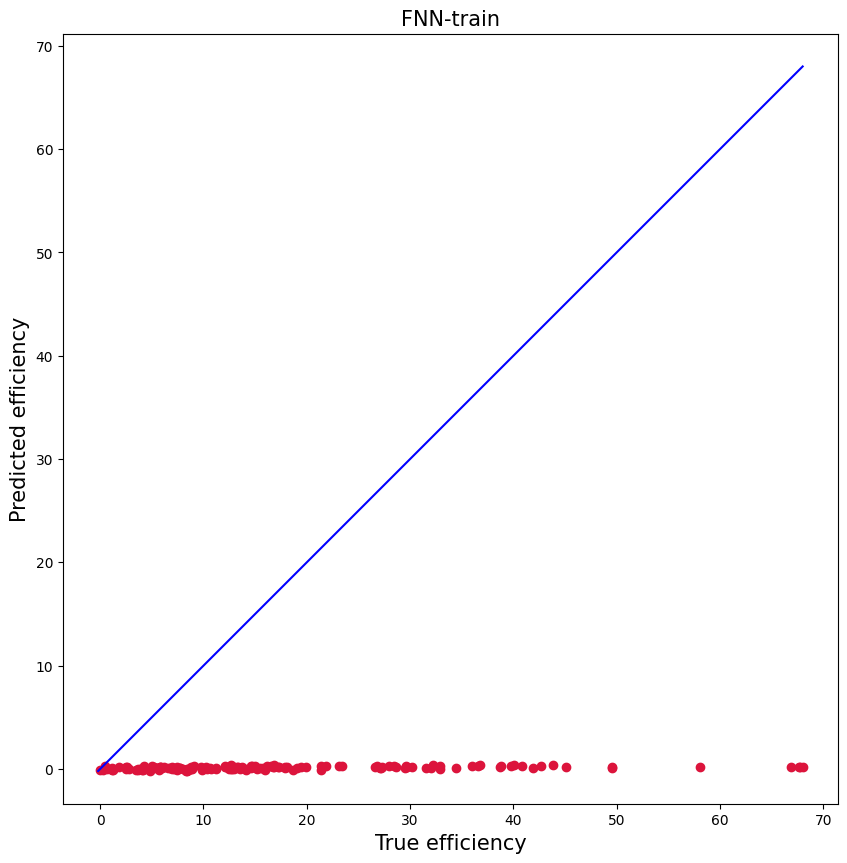

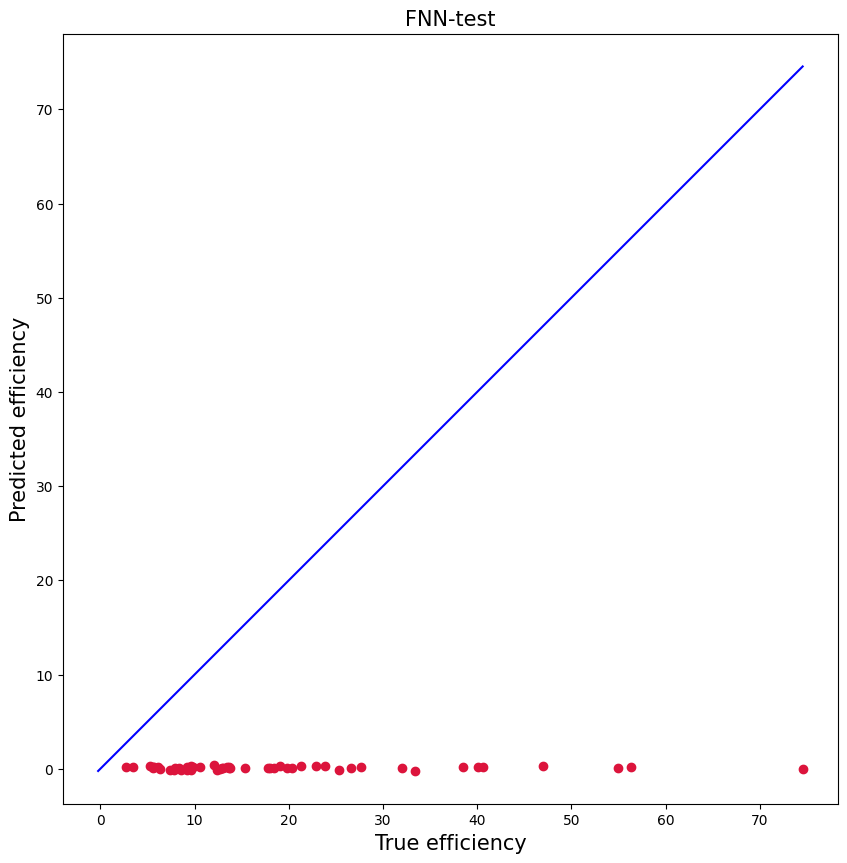

In [36]:
plot_true_v_pred(inv_y_train, inv_y_hat_train, 'FNN-train')
plot_true_v_pred(inv_y_test, inv_y_hat_test, 'FNN-test')

In [44]:
display_metrics(inv_y_train, inv_y_hat_train, 'FNN-train')


** FNN-train **
Mean Absolute Error (MAE): 17.371467225687113
Mean Squared Error (MSE): 516.3038515538022
Root Mean Squared Error (RMSE): 22.722320558292505
Mean Absolute Percentage Error (MAPE): 1.194525569159538
Explained Variance Score: 0.007499393292382028
Max Error: 67.84613919258115
Median Absolute Error: 13.125361061096187
R^2: -1.3885592092099994


In [46]:
display_metrics(inv_y_test, inv_y_hat_test, 'FNN-train')


** FNN-train **
Mean Absolute Error (MAE): 18.900110887657505
Mean Squared Error (MSE): 586.2171238849902
Root Mean Squared Error (RMSE): 24.21192111099386
Mean Absolute Percentage Error (MAPE): 0.9900787594915949
Explained Variance Score: 0.0009039167350769484
Max Error: 74.57956545352927
Median Absolute Error: 13.334971094131467
R^2: -1.5575534185730304


In [39]:
r2_score(y_train, y_hat_train.detach().numpy())

-6.059786109267433

In [40]:
r2_score(y_test, y_hat_test.detach().numpy())

-9.715489758278999

In [41]:
y_hat_test.detach().numpy()

array([[-0.10388994],
       [ 0.06280766],
       [ 0.01238262],
       [-0.02992586],
       [-0.25507694],
       [ 0.03762389],
       [ 0.13482976],
       [-0.02388964],
       [ 0.1912161 ],
       [ 0.10010128],
       [ 0.21766241],
       [ 0.13191606],
       [ 0.06226663],
       [ 0.24525477],
       [ 0.1305587 ],
       [-0.13587679],
       [ 0.12312941],
       [ 0.20249464],
       [-0.10657027],
       [ 0.24949624],
       [ 0.13421832],
       [ 0.07922855],
       [-0.15592006],
       [ 0.17007849],
       [ 0.16862091],
       [ 0.18434595],
       [ 0.16957143],
       [ 0.11088151],
       [-0.10234542],
       [ 0.31176174],
       [ 0.30419508],
       [-0.11900339],
       [-0.12025107],
       [ 0.05935441],
       [ 0.04929008],
       [ 0.25830558],
       [ 0.12404463],
       [ 0.15621242],
       [ 0.07668763],
       [ 0.24879895],
       [ 0.15493599],
       [ 0.18699475],
       [ 0.04355941],
       [ 0.24200796],
       [ 0.16492891],
       [ 0

In [42]:
y_test

82     3.276115
15     3.346879
111    3.310514
177    6.450236
76     4.891937
163    2.726098
68     2.347496
67     2.391634
120    2.861779
173    4.815896
176    3.394149
148    3.050001
65     3.420082
30     2.157364
86     3.434887
85     4.406985
55     2.239979
60     2.956720
90     2.770039
159    3.940293
16     3.421568
124    3.998169
96     2.646456
172    5.879071
66     4.555690
189    1.710568
147    5.221925
9      2.665178
18     2.579244
128    3.244886
190    5.522511
45     2.918300
192    2.862513
164    4.493044
101    4.039985
69     2.927981
126    3.603370
123    5.146305
75     3.333971
78     4.302320
183    2.243216
38     5.247357
24     3.880727
142    4.236616
141    2.233774
29     3.850275
19     5.829181
169    3.832666
127    1.479379
118    4.113113
Name: yj_eff, dtype: float64